In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import locale

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from analysis import InformationValue, frequency_table, r2, calculate_performance, skf_split, skf_metrics, cv_recall_score

from hyperopt import hp, tpe, fmin, Trials, STATUS_OK

# Métricas de Desempenho
from scipy.stats import ks_2samp
from sklearn.metrics import (accuracy_score, 
                            classification_report,
                            confusion_matrix, 
                            f1_score, 
                            precision_score, 
                            recall_score, 
                            roc_auc_score, 
                            roc_curve)

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

from sklearn.preprocessing import StandardScaler


# Exibir todo o conteúdo de uma célula, sem truncar o texto
pd.set_option('display.max_colwidth', None)

# Definir a formatação local para o Brasil
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

# Definir um alias para a função locale.format_string()
def valor(valor):
    return locale.format_string('%.2f', valor, grouping=True)

In [2]:
df_churn = pd.read_csv('data/db_churn.csv', sep=';', index_col='ClientId')
df_churn.head()

DataExtracao  Score_Credito          Estado    Gênero  Idade  \
ClientId                                                                
345568     2019-06-30            619       São Paulo  Feminino     42   
345569     2019-06-30            608  Rio de Janeiro  Feminino     41   
345570     2019-06-30            502       São Paulo  Feminino     42   
345571     2019-06-30            699       São Paulo  Feminino     39   
345572     2019-06-30            850  Rio de Janeiro  Feminino     43   

          Tempo_Cliente  Limite_Credito_Mercado  Qte_Categorias  \
ClientId                                                          
345568                2                  0.0000               1   
345569                1                838.0786               1   
345570                8               1596.6080               3   
345571                1                  0.0000               2   
345572                2               1255.1082               1   

          Usa_Cartao_Credito  Programa_Fidelidade  Sum_Pedidos_Acumulados  \
ClientId                                                                    
345568                     1                    1              422.287000   
345569                     0                    1              468.927417   
345570                     1                    0              474.714875   
345571                     0                    0              390.944292   
345572                     1                    1              329.517083   

         DataUltimaTransacao  
ClientId                      
345568            2019-09-14  
345569            2019-10-05  
345570            2019-08-20  
345571            2019-10-21  
345572            2019-10-26

In [3]:
metadados = pd.read_excel('data/Metadados.xlsx', index_col='Variável')
metadados

Descrição
Variável                                                                                                                                                                                                          
ClientId                                                                                                                                                                       Identificador de cliente (campo PK)
DataExtracao                                                                                                                                                       Data da extração dessa visão de clientes (foto)
Score_Credito                                    Score de Crédito no mercado. A empresa comprou essa variável de um Bureau de Crédito. Quanto mais próximo de 1000, melhor é o cliente em relação a inadimplência.
Estado                                                                                                                                                                                           Estado do cliente
Gênero                                                                                                                                                                                           Genero do cliente
Idade                                                                                                                                                                                             Idade do cliente
Tempo_Cliente                                                                                                                                                 Tempo em meses em que o cliente utiliza o aplicativo
Limite_Credito_Mercado  Limite de Crédito que o cliente tem no mercado. A empresa comprou essa variável de um Bureau de Crédito. Quanto maior é o limite, maior é a chance do cliente ter um bom poder aquisitivo.
Qte_Categorias                                                                  Qte de categorias de produtos (ex: lanches, comida japonesa, doces etc) pedidos nos ultimos 3 meses anteriores à data de extração.
Usa_Cartao_Credito                                                                                                 Flag se cliente cadastrou um cartão de crédito no aplicativo. 1 = Cadastrou e 0 = Não Cadastrou
Programa_Fidelidade                                                                                       Flag se cliente participa de um programa de fidelidade no aplicativo. 1 = Participa e 0 = Não Participa.
Sum_Pedidos_Acumulados                                                                                                              Valores gastos no aplicativo nos ultimos 3 meses anteriores à data de extração
DataUltimaTransacao                                                                    A data da última transação realizada por cada cliente, extraída no dia 30/10/2019 às 23h59min do cliente no aplicativo

In [4]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 345568 to 355567
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DataExtracao            10000 non-null  object 
 1   Score_Credito           10000 non-null  int64  
 2   Estado                  10000 non-null  object 
 3   Gênero                  10000 non-null  object 
 4   Idade                   10000 non-null  int64  
 5   Tempo_Cliente           10000 non-null  int64  
 6   Limite_Credito_Mercado  10000 non-null  float64
 7   Qte_Categorias          10000 non-null  int64  
 8   Usa_Cartao_Credito      10000 non-null  int64  
 9   Programa_Fidelidade     10000 non-null  int64  
 10  Sum_Pedidos_Acumulados  10000 non-null  float64
 11  DataUltimaTransacao     10000 non-null  object 
dtypes: float64(2), int64(6), object(4)
memory usage: 1015.6+ KB


In [5]:
# Converter colunas de data para datetime
datetime_variables = ['DataExtracao', 'DataUltimaTransacao']
for column in datetime_variables:
    df_churn[column] = pd.to_datetime(df_churn[column])

df_churn[datetime_variables].info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 345568 to 355567
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DataExtracao         10000 non-null  datetime64[ns]
 1   DataUltimaTransacao  10000 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 234.4 KB


In [6]:
df_churn.duplicated().sum()

0

In [7]:
# Separando as variáveis quantitativas (numéricas) das demais variáveis
numerical_variables = df_churn.select_dtypes(include=['number'])

# Removendo as Flags armazenadas como número
numerical_variables.drop(['Usa_Cartao_Credito', 'Programa_Fidelidade'] , axis=1, inplace=True)

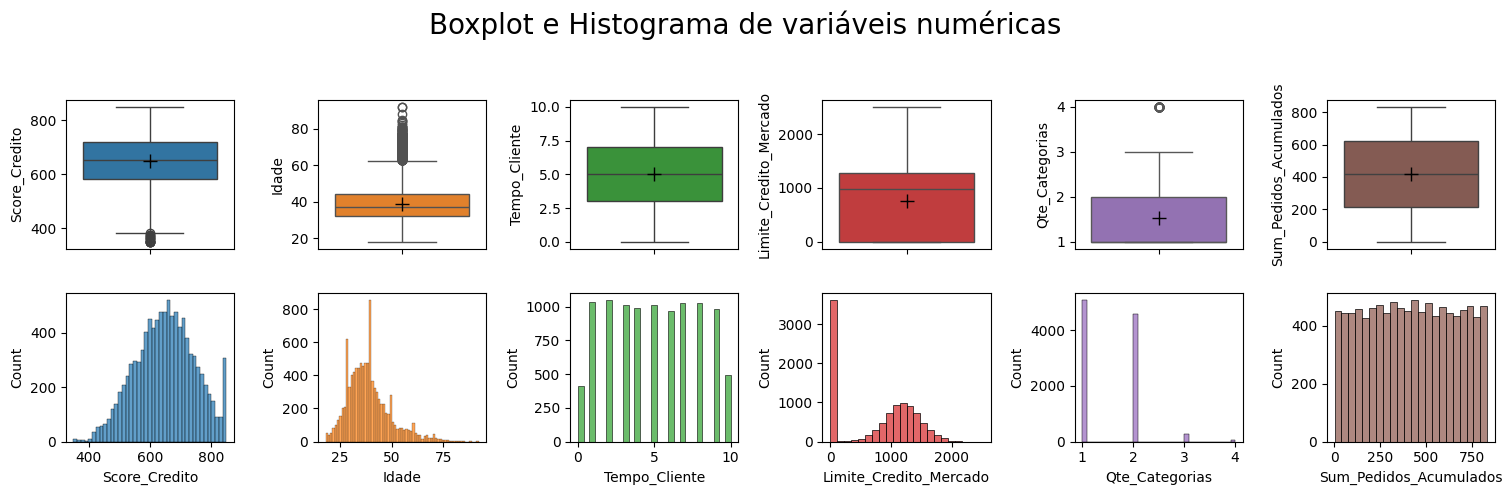

In [8]:
# Boxplots e histogramas
def plot_boxplot_and_histogram(dataframe):
    # Configuração do tamanho do gráfico
    plt.figure(figsize=(15, 5))

    # Criar uma paleta de cores com uma cor diferente para cada variável
    colors = sns.color_palette("tab10", len(dataframe.columns))

    # Iterar sobre cada feature e criar boxplot e histograma
    for i, var in enumerate(dataframe.columns, 1):
        # Subplot para boxplot
        plt.subplot(2, dataframe.shape[1], i)
        sns.boxplot(data=dataframe[var], showmeans=True,
                    meanprops={"marker": "+",
                               "markeredgecolor": "black",
                               "markersize": "10"}, color=colors[i-1])

        # Subplot para histograma
        plt.subplot(2, dataframe.shape[1], i + dataframe.shape[1])
        sns.histplot(data=dataframe, x=var, alpha=0.7, color=colors[i-1], edgecolor='black')

    # Configuração do título
    plt.suptitle('Boxplot e Histograma de variáveis numéricas', fontsize=20)

    plt.tight_layout()
    plt.subplots_adjust(
        top=0.8, right=1, # Ajustar a posição do título
        wspace=0.5, hspace=0.3) # Ajustar os espaçamentos entre os plots

    plt.show()

# plotando a função com 'numerical_variables'
plot_boxplot_and_histogram(numerical_variables)

numerical_variables.describe().style.format('{:.2f}')

In [9]:
# Definindo os limites das faixas de classificação do Score
limites_faixas = [0, 301, 501, 701, 1000]

# Definir os rótulos para as faixas
rotulos_faixas = ['Muito baixo', 'Baixo', 'Bom', 'Excelente']

# Criar uma nova coluna 'Classe_Score'
df_churn['Classe_Score'] = pd.cut(df_churn['Score_Credito'], bins=limites_faixas, labels=rotulos_faixas, right=False)

In [10]:
# Separando as variáveis qualitativas (categóricas) das demais variáveis
categorical_variables = df_churn.select_dtypes(include=['object', 'category'])

# Incluindo as Flags armazenadas como número
categorical_variables[['Usa_Cartao_Credito', 'Programa_Fidelidade']] = df_churn[['Usa_Cartao_Credito', 'Programa_Fidelidade']]



# Tabelas de frequência
for var in categorical_variables.columns:
  print("\nTabela frequência de", var)
  display(frequency_table(categorical_variables, var))


Tabela frequência de Estado


Frequência Absoluta Frequência Relativa Frequência Acumulada
Estado                                                                      
São Paulo                      5014              50.14%               50.14%
Minas Gerais                   2509              25.09%               75.23%
Rio de Janeiro                 2477              24.77%              100.00%


Tabela frequência de Gênero


Frequência Absoluta Frequência Relativa Frequência Acumulada
Gênero                                                                 
Masculino                 5457              54.57%               54.57%
Feminino                  4543              45.43%              100.00%


Tabela frequência de Classe_Score


Frequência Absoluta Frequência Relativa Frequência Acumulada
Classe_Score                                                              
Muito baixo                     0               0.00%                0.00%
Baixo                         643               6.43%                6.43%
Bom                          6241              62.41%               68.84%
Excelente                    3116              31.16%              100.00%


Tabela frequência de Usa_Cartao_Credito


Frequência Absoluta Frequência Relativa  \
Usa_Cartao_Credito                                            
1                                  7055              70.55%   
0                                  2945              29.45%   

                   Frequência Acumulada  
Usa_Cartao_Credito                       
1                                70.55%  
0                               100.00%


Tabela frequência de Programa_Fidelidade


Frequência Absoluta Frequência Relativa  \
Programa_Fidelidade                                            
1                                   5151              51.51%   
0                                   4849              48.49%   

                    Frequência Acumulada  
Programa_Fidelidade                       
1                                 51.51%  
0                                100.00%

In [11]:
# Criando a variável 'data_corte_churn' para definir a data base como referência de corte.
data_corte_churn = pd.to_datetime('2019-10-30') - pd.to_timedelta(30, unit='d')
print(f'Data de corte: {data_corte_churn}')

# Criar a variável Churn
df_churn['Churn'] = (df_churn['DataUltimaTransacao'] <= data_corte_churn).astype(int)
taxa_churn = df_churn['Churn'].mean()

print(f'Taxa de churn: {taxa_churn:.2%}')

Data de corte: 2019-09-30 00:00:00
Taxa de churn: 20.37%


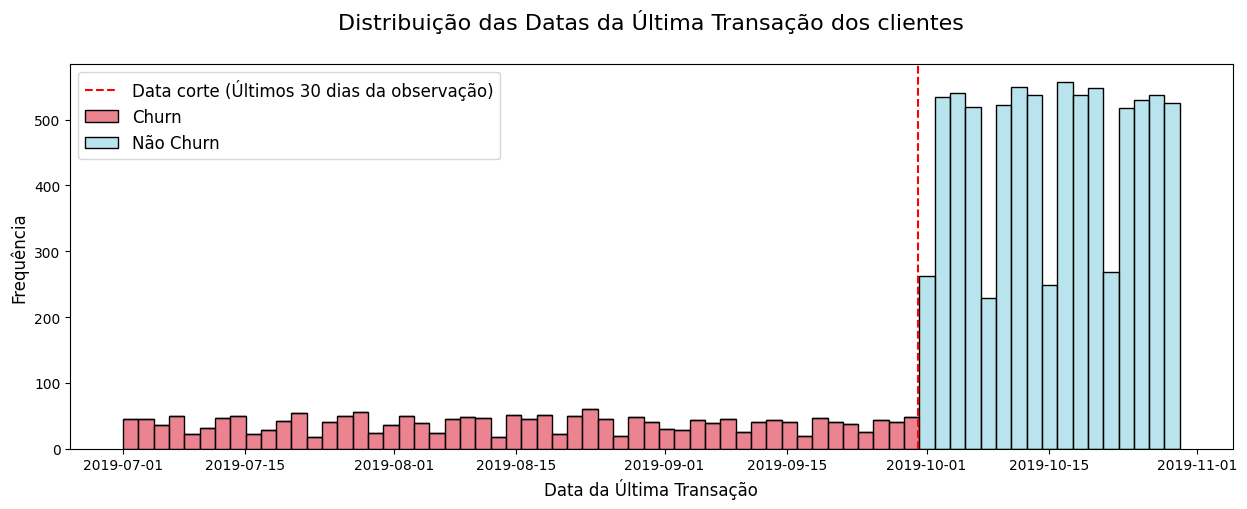

In [12]:
# Plotando o histograma com diferentes cores para as barras usando a coluna 'Churn'
plt.figure(figsize=(15, 5))
sns.histplot(data=df_churn, x='DataUltimaTransacao', hue='Churn', palette={1: '#e65a6d', 0: '#a3dce8'}, multiple='stack')

# Adicionando a linha vertical para a data de corte
plt.axvline(data_corte_churn, color='red', linestyle='--')

# Configurando o gráfico
plt.title('Distribuição das Datas da Última Transação dos clientes', pad=25, fontsize=16)
plt.xlabel('Data da Última Transação', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.legend(labels=['Data corte (Últimos 30 dias da observação)', 'Churn', 'Não Churn'], fontsize=12)
plt.show()

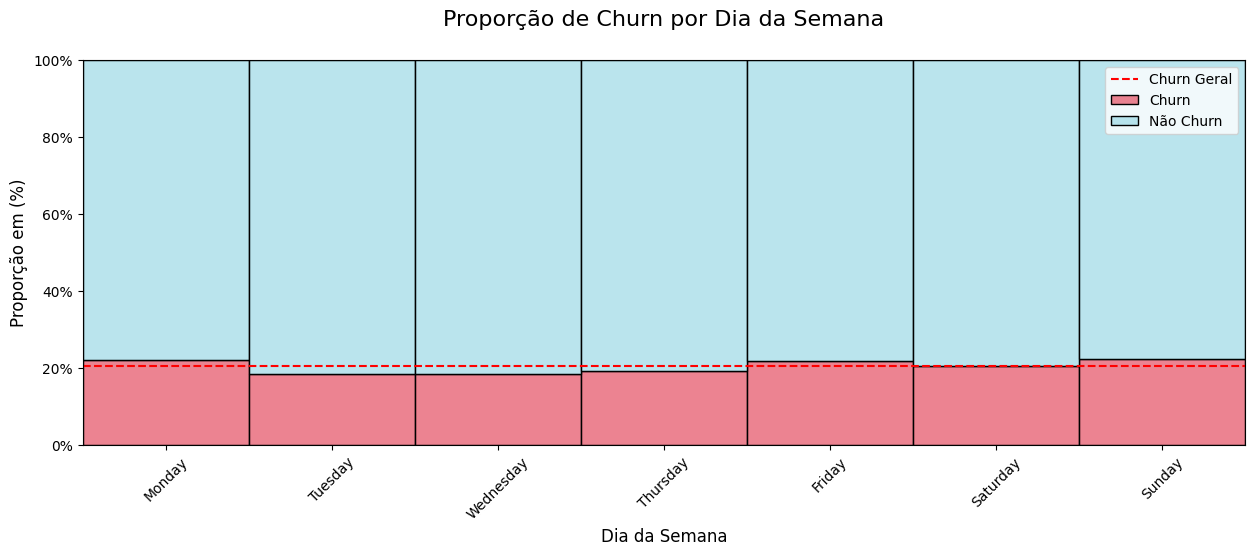

In [13]:
import matplotlib.ticker as mtick

# Adicionar coluna de dia da semana
df_churn['DiaSemana'] = df_churn['DataUltimaTransacao'].dt.day_name()

# Reordenar a coluna 'DiaSemana'
ordem_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_churn['DiaSemana'] = pd.Categorical(df_churn['DiaSemana'], categories=ordem_dias, ordered=True)


# Plotar a distribuição por dia da semana para churn e não churn
plt.figure(figsize=(15, 5))
sns.histplot(data=df_churn, x='DiaSemana', hue='Churn', multiple='fill', palette={1: '#e65a6d', 0: '#a3dce8'})
plt.title('Proporção de Churn por Dia da Semana', pad=25, fontsize=16)
plt.xlabel('Dia da Semana', fontsize=12)
plt.ylabel('Proporção em (%)', fontsize=12)
plt.xticks(rotation=45)

# Alterar o eixo y para porcentagem
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

# Inserir uma linha horizontal
plt.axhline(taxa_churn, color='red', linestyle='--')

plt.legend(labels=['Churn Geral', 'Churn', 'Não Churn'])
plt.show()

In [14]:
# Instanciar InformationValue
iv = InformationValue(df_churn, 'Churn')

# Calcular o Information Value
iv.calculate_iv()

# Agrupando as variáveis Idade e Limite_Credito_Mercado
iv.set_grouping('Idade',por=10, finalizar_em=58)
iv.set_grouping('Limite_Credito_Mercado',por=500, finalizar_em=2000)
iv.calculate_iv()

# Poder de separação/discriminação das variáveis em relação ao Churn
iv.get_iv_predict()

IV poder_separação
Variável                                        
Qte_Categorias_bin          0.84     Muito Forte
Idade_bin                   0.69     Muito Forte
Estado                      0.17           Médio
Programa_Fidelidade_bin     0.15           Médio
Limite_Credito_Mercado_bin  0.10           Médio
Gênero                      0.07           Fraco
DiaSemana                   0.01     Muito fraco
Score_Credito_bin           0.01     Muito fraco
Classe_Score                0.00     Muito fraco
Tempo_Cliente_bin           0.00     Muito fraco
Usa_Cartao_Credito_bin      0.00     Muito fraco
Sum_Pedidos_Acumulados_bin  0.00     Muito fraco

In [15]:
iv.visualize_results(min_iv=0.1)


                           Resultados de Information Value para 'Estado' e 'Churn'                           
╭────────────────┬────────┬───────┬───────┬─────────┬────────┬────────┬─────────────┬────────┬───────┬──────╮
│ Estado         │   freq │   sim │   não │   %freq │ %sim   │ %não   │   %taxa_sim │ Odds   │ WoE   │   IV │
├────────────────┼────────┼───────┼───────┼─────────┼────────┼────────┼─────────────┼────────┼───────┼──────┤
│ Minas Gerais   │   2509 │   814 │  1695 │   25.09 │ 39.96  │ 21.29  │       32.44 │ 1.88   │ 0.63  │ 0.12 │
├────────────────┼────────┼───────┼───────┼─────────┼────────┼────────┼─────────────┼────────┼───────┼──────┤
│ Rio de Janeiro │   2477 │   413 │  2064 │   24.77 │ 20.27  │ 25.92  │       16.67 │ 0.78   │ -0.25 │ 0.01 │
├────────────────┼────────┼───────┼───────┼─────────┼────────┼────────┼─────────────┼────────┼───────┼──────┤
│ São Paulo      │   5014 │   810 │  4204 │   50.14 │ 39.76  │ 52.79  │       16.15 │ 0.75   │ -0.28 │ 0.04 │
├────────

In [16]:
iv.visualize_results(max_iv=0.1)


                        Resultados de Information Value para 'Gênero' e 'Churn'                         
╭───────────┬────────┬───────┬───────┬─────────┬────────┬────────┬─────────────┬────────┬───────┬──────╮
│ Gênero    │   freq │   sim │   não │   %freq │ %sim   │ %não   │   %taxa_sim │ Odds   │ WoE   │   IV │
├───────────┼────────┼───────┼───────┼─────────┼────────┼────────┼─────────────┼────────┼───────┼──────┤
│ Feminino  │   4543 │  1139 │  3404 │   45.43 │ 55.92  │ 42.75  │       25.07 │ 1.31   │ 0.27  │ 0.04 │
├───────────┼────────┼───────┼───────┼─────────┼────────┼────────┼─────────────┼────────┼───────┼──────┤
│ Masculino │   5457 │   898 │  4559 │   54.57 │ 44.08  │ 57.25  │       16.46 │ 0.77   │ -0.26 │ 0.03 │
├───────────┼────────┼───────┼───────┼─────────┼────────┼────────┼─────────────┼────────┼───────┼──────┤
│ Total     │  10000 │  2037 │  7963 │  100    │        │        │       20.37 │        │       │ 0.07 │
╰───────────┴────────┴───────┴───────┴─────────┴──────

In [17]:
numerical_variables.corr(numeric_only=True).style.background_gradient(axis=None, vmin=-1, vmax=1, cmap='RdBu').format(precision=2)

<Figure size 1500x800 with 0 Axes>

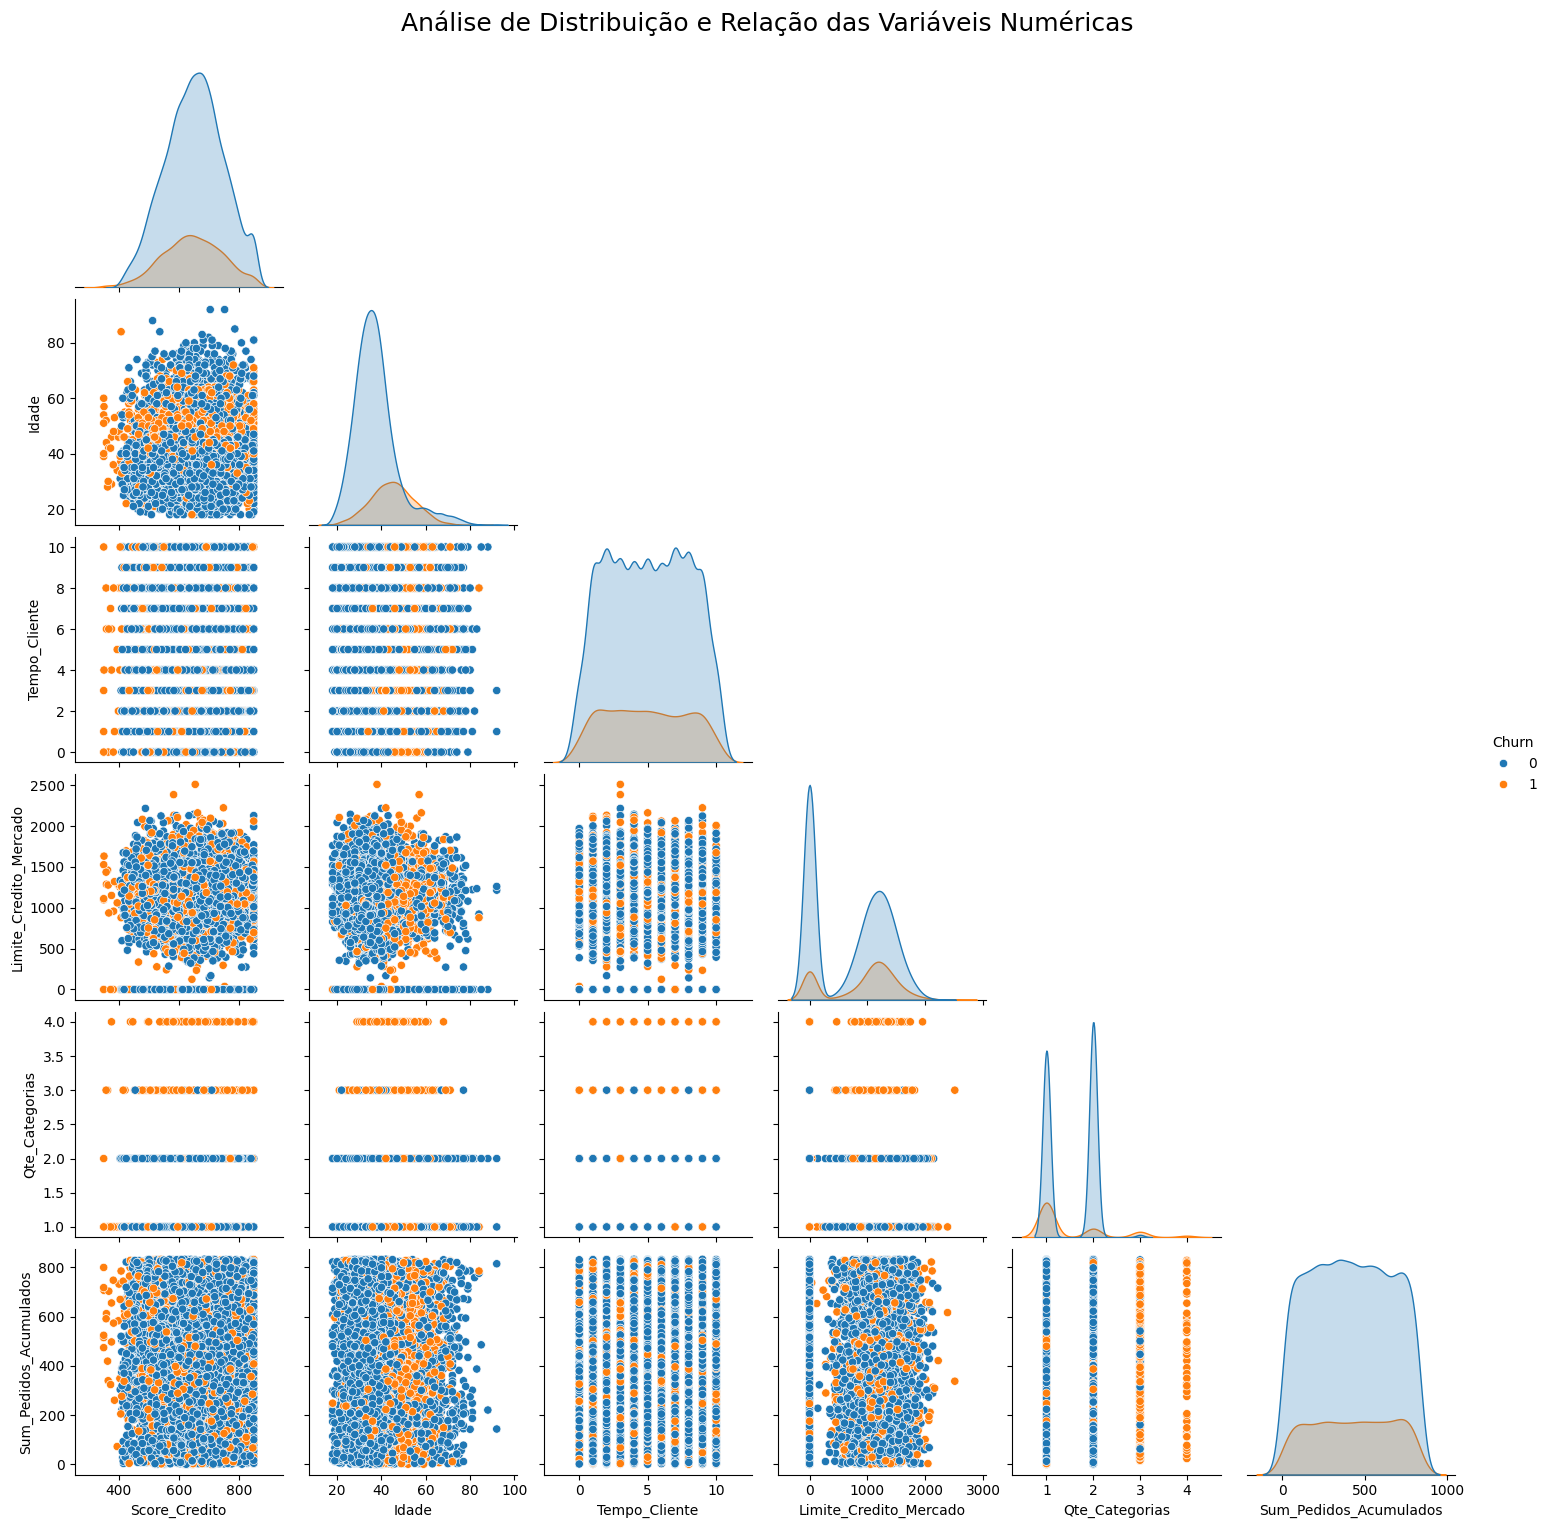

In [18]:
plt.figure(figsize=(15, 8))
pairplot = sns.pairplot(df_churn[list(numerical_variables.columns) + ['Churn']], hue='Churn', corner=True)

# Adiciona o título ao gráfico
pairplot.figure.suptitle('Análise de Distribuição e Relação das Variáveis Numéricas', fontsize=18, y=1.02)

plt.show()

In [19]:
# Dicionário para armazenar os resultados em formato de matriz
resultados = {}

# Iterando entre as variáveis categóricas para calcular o r2
for categorical in categorical_variables.columns:
    resultados[categorical] = {}  # Inicializa o dicionário para cada categoria
    for numerical in numerical_variables.columns:
        # Calcula o valor de r2 e armazena no dicionário
        resultados[categorical][numerical] = r2(df_churn, categorical, numerical)[2]  # Armazena o valor do r2

# Criação do DataFrame a partir do dicionário de resultados
df_resultados = pd.DataFrame(resultados).T  # Transpõe o DataFrame para alinhar categóricas nas linhas e numéricas nas colunas

# Exibição do DataFrame
df_resultados.style\
    .background_gradient(axis=None, vmin=0, vmax=1, cmap='Blues')\
    .format("{:.2%}")  # Formata os valores como porcentagens com 2 casas decimais

In [20]:
iv.get_iv_predict()

IV poder_separação
Variável                                        
Qte_Categorias_bin          0.84     Muito Forte
Idade_bin                   0.69     Muito Forte
Estado                      0.17           Médio
Programa_Fidelidade_bin     0.15           Médio
Limite_Credito_Mercado_bin  0.10           Médio
Gênero                      0.07           Fraco
DiaSemana                   0.01     Muito fraco
Score_Credito_bin           0.01     Muito fraco
Classe_Score                0.00     Muito fraco
Tempo_Cliente_bin           0.00     Muito fraco
Usa_Cartao_Credito_bin      0.00     Muito fraco
Sum_Pedidos_Acumulados_bin  0.00     Muito fraco

In [21]:
df = df_churn[['Qte_Categorias', 'Idade', 'Estado', 'Programa_Fidelidade', 'Churn']].copy()
df.head()

Qte_Categorias  Idade          Estado  Programa_Fidelidade  Churn
ClientId                                                                   
345568                 1     42       São Paulo                    1      1
345569                 1     41  Rio de Janeiro                    1      0
345570                 3     42       São Paulo                    0      1
345571                 2     39       São Paulo                    0      0
345572                 1     43  Rio de Janeiro                    1      0

In [22]:
# Criando variáveis Dummy
df_prep = pd.get_dummies(df, drop_first=True, dtype=int)

# Divisão entre features e target
X = df_prep.drop(columns=['Churn'])
y = df_prep['Churn']

# Divisão entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [23]:
# Padronização da Escala usando conjunto de treino
x_scaler = StandardScaler()
x_scaler.fit(X_train)

columns = X.columns

X_train_scaled = pd.DataFrame()
X_test_scaled = pd.DataFrame()

X_train_scaled[columns] = x_scaler.transform(X_train[columns])
X_test_scaled[columns] = x_scaler.transform(X_test[columns])

In [24]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)
performance_logreg_baseline = calculate_performance(logreg, X_train_scaled, y_train, X_test_scaled, y_test)
performance_logreg_baseline.style.background_gradient(axis=1, subset=['Teste', 'Treino']).format(precision=3)

In [25]:
variavel = logreg.feature_names_in_
intercept = logreg.intercept_[0]
coef = logreg.coef_.ravel()

beta = pd.DataFrame({"Variável": ['Intercepto'] + list(variavel),
              "Coeficientes": [intercept] + list(coef),
              "Odds": [np.exp(intercept)] + list(np.exp(coef)),
              "Aumento" : [None] + list(np.exp(coef) - 1),
              "Diminuição" : [None] + list(np.exp(-coef) - 1)
              })

beta

Variável  Coeficientes      Odds   Aumento  Diminuição
0             Intercepto     -1.599524  0.201993       NaN         NaN
1         Qte_Categorias     -0.059686  0.942061 -0.057939    0.061503
2                  Idade      0.705463  2.024784  1.024784   -0.506120
3    Programa_Fidelidade     -0.513131  0.598618 -0.401382    0.670513
4  Estado_Rio de Janeiro     -0.400861  0.669743 -0.330257    0.493109
5       Estado_São Paulo     -0.472557  0.623406 -0.376594    0.604091

In [26]:
beta.iloc[0]['Odds']

0.2019927216123274

In [27]:
print(f"Variável: {beta.iloc[1]['Variável']}")
print(f"Aumento: {(beta.iloc[1]['Aumento']):.2%}")
print(f"Diminuição: {(beta.iloc[1]['Diminuição']):.2%}")

Variável: Qte_Categorias
Aumento: -5.79%
Diminuição: 6.15%


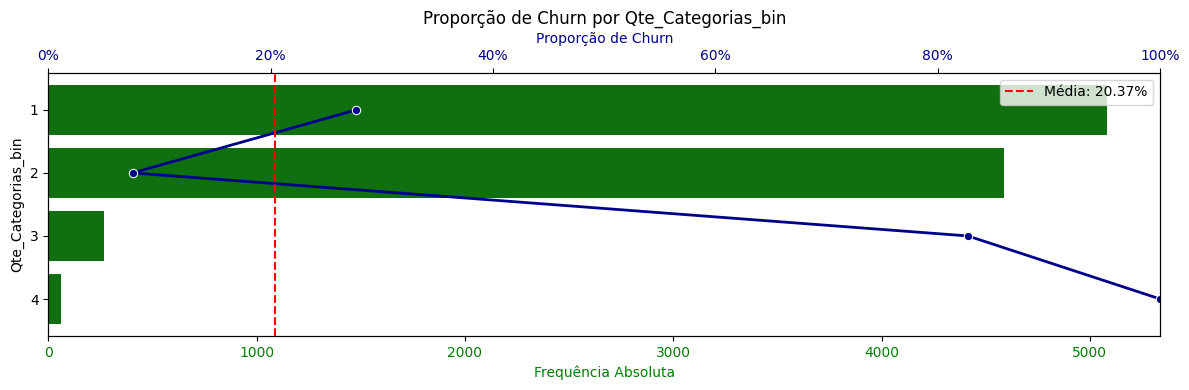

In [28]:
iv.plot_bivariada('Qte_Categorias_bin')

In [29]:
print(f"Variável: {beta.iloc[2]['Variável']}")
print(f"Aumento: {(beta.iloc[2]['Aumento']):.2%}")
print(f"Diminuição: {(beta.iloc[2]['Diminuição']):.2%}")

Variável: Idade
Aumento: 102.48%
Diminuição: -50.61%


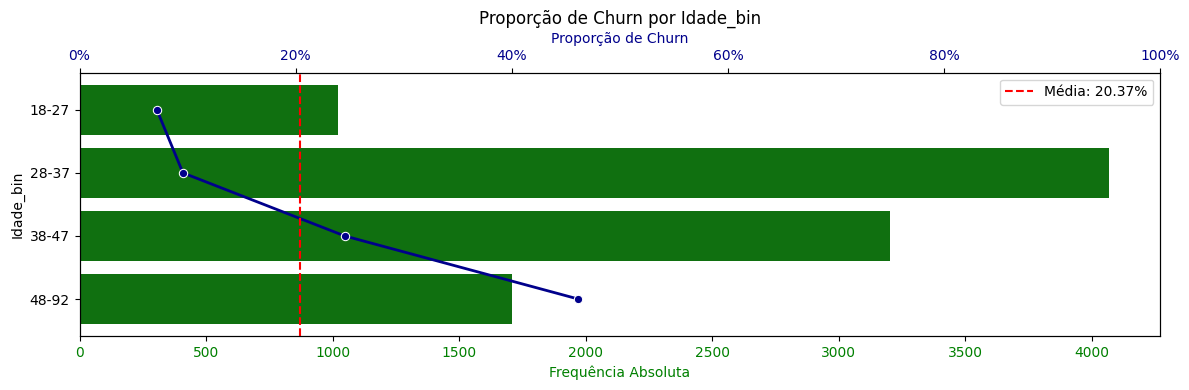

In [30]:
iv.plot_bivariada('Idade_bin')

In [31]:
print(f"Variável: {beta.iloc[3]['Variável']}")
print(f"Aumento: {(beta.iloc[3]['Aumento']):.2%}")
print(f"Diminuição: {(beta.iloc[3]['Diminuição']):.2%}")

Variável: Programa_Fidelidade
Aumento: -40.14%
Diminuição: 67.05%


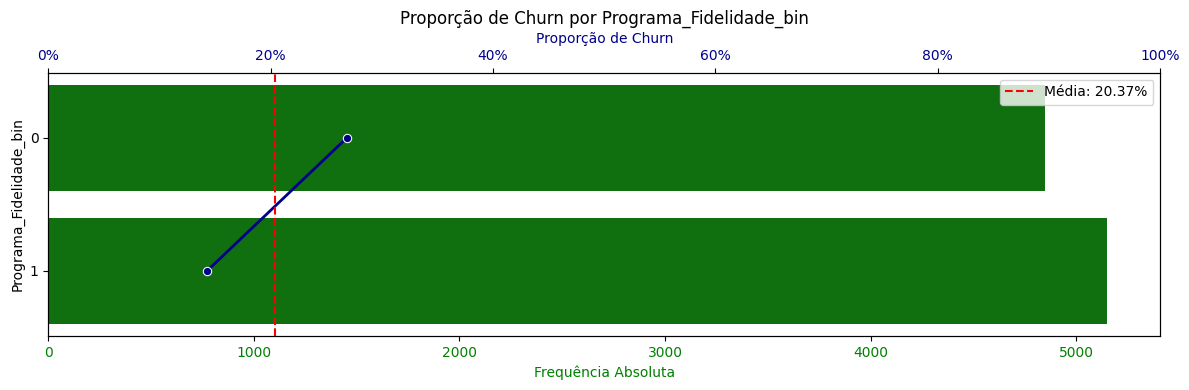

In [32]:
iv.plot_bivariada('Programa_Fidelidade_bin')

In [33]:
print(f"Variável: {beta.iloc[4]['Variável']}")
print(f"Aumento: {(beta.iloc[4]['Aumento']):.2%}")
print(f"Diminuição: {(beta.iloc[4]['Diminuição']):.2%}")

Variável: Estado_Rio de Janeiro
Aumento: -33.03%
Diminuição: 49.31%


In [34]:
print(f"Variável: {beta.iloc[5]['Variável']}")
print(f"Aumento: {(beta.iloc[5]['Aumento']):.2%}")
print(f"Diminuição: {(beta.iloc[5]['Diminuição']):.2%}")

Variável: Estado_São Paulo
Aumento: -37.66%
Diminuição: 60.41%


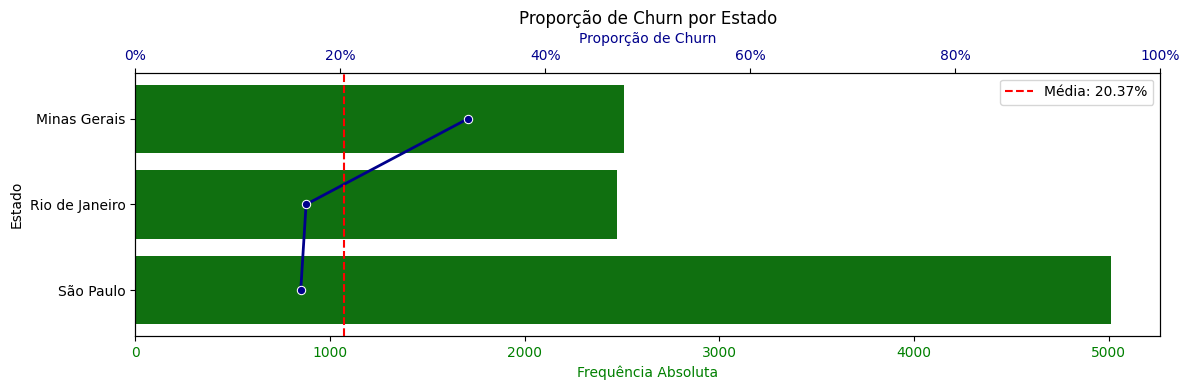

In [35]:
iv.plot_bivariada('Estado')

In [36]:
df_churn.head().to_clipboard()

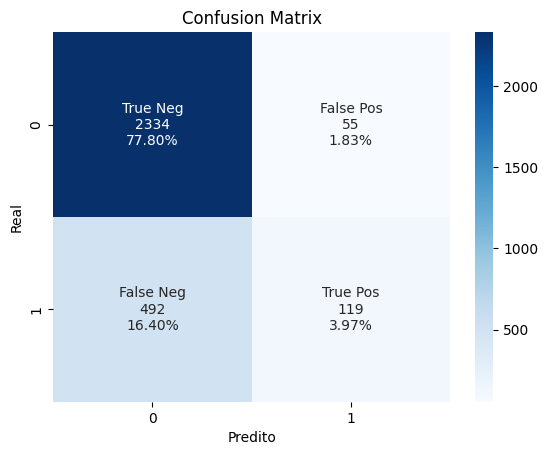

              precision    recall  f1-score   support

           0       0.83      0.98      0.90      2389
           1       0.68      0.19      0.30       611

    accuracy                           0.82      3000
   macro avg       0.75      0.59      0.60      3000
weighted avg       0.80      0.82      0.77      3000



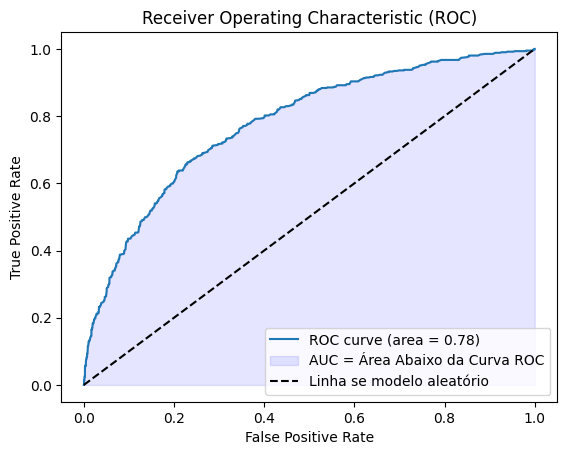

In [37]:
# Previsões no conjunto de teste
y_pred = logreg.predict(X_test_scaled)
y_prob = logreg.predict_proba(X_test_scaled)[:, 1]

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()

# Relatório de classificação
print(classification_report(y_test, y_pred))

# AUC-ROC
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.fill_between(fpr,tpr,color='blue',alpha= 0.1,label = 'AUC = Área Abaixo da Curva ROC')
plt.plot([0, 1], [0, 1], 'k--', label='Linha se modelo aleatório')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [38]:
n_cliente = 10_000

# Ticket Médio Mensal
ticket_medio_mensal = df_churn['Sum_Pedidos_Acumulados'] / 3  # soma de pedidos acumulados nos últimos 3 meses

# LTV médio (Lifetime Value)
LTV = (df_churn['Tempo_Cliente'] * ticket_medio_mensal).mean()
print(f'LTV médio (estimado com base na amostra dos 10.000 clientes): R$ {valor(LTV)}.')

# Custo de Aquisição de Cliente
CAC = 150.00

# Cupom de desconto para manter o cliente comprando
CUPOM = 30.00

LTV médio (estimado com base na amostra dos 10.000 clientes): R$ 698,65.


In [39]:
# Clientes que irão dar churn e foram corretamente classificados como churn pelo modelo.
impacto_TP = LTV - CAC - CUPOM

In [40]:
# Clientes que NÃO irão dar churn e foram corretamente classificados como não churn pelo modelo.
impacto_TN = LTV - CAC # Não temos custos adicionais para retenção desses clientes

In [41]:
# Clientes que NÃO irão dar churn, mas foram incorretamente classificados como churn pelo modelo.
impacto_FP = impacto_TP - impacto_TN # Ganhamos o mesmo valor de TP, mas perdemos a oportunidade de ganho de TN caso o modelo acertasse.

In [42]:
# Clientes que irão dar churn, mas foram incorretamente classificados como não churn pelo modelo.
impacto_FN = - impacto_TP # Perdemos a oportunidade de ganho caso o modelo acertasse.

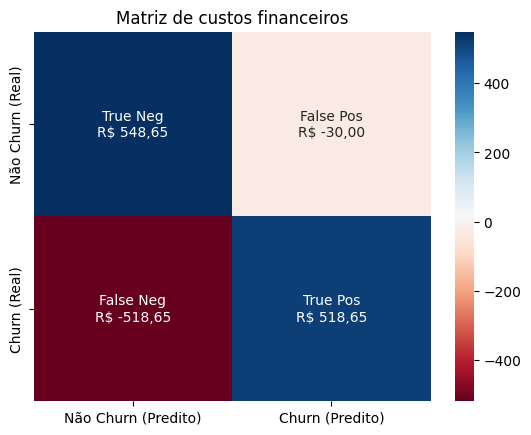

In [43]:
# Criar a matriz de custos financeiros
matriz_custos = np.array([[impacto_TN, impacto_FP],
                          [impacto_FN, impacto_TP]])


group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = [f"R$ {valor(value)}" for value in matriz_custos.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matriz_custos, annot=labels, fmt='', cmap='RdBu')

# Alterar os nomes dos eixos
plt.xticks(ticks=[0.5, 1.5], labels=['Não Churn (Predito)', 'Churn (Predito)'], fontsize=10)
plt.yticks(ticks=[0.5, 1.5], labels=['Não Churn (Real)', 'Churn (Real)'], fontsize=10)


plt.title('Matriz de custos financeiros')
plt.show()

In [44]:
# Inicia o estimador base para o Bagging
modelo_bagging_lr = LogisticRegression(max_iter=1000)

# Classificador de Bagging
modelo_bagging_lr = BaggingClassifier(estimator = modelo_bagging_lr, 
                                   n_estimators = 100, 
                                   max_samples=0.5,
                                   random_state = 42) 

# Ajuste do Modelo
modelo_bagging_lr.fit(X_train_scaled, y_train)

# Métricas de Desempenho
performance_bagging_lr = calculate_performance(modelo_bagging_lr, X_train_scaled, y_train, X_test_scaled, y_test)
performance_bagging_lr.style.background_gradient(axis=1, subset=['Teste', 'Treino']).format(precision=3)

In [45]:
df = df_churn[['Estado', 'Idade', 'Qte_Categorias', 'Programa_Fidelidade', 'Churn']].copy()

# Pré-processamento
data = pd.get_dummies(df, drop_first=False, dtype=int)

# Divisão entre features e target
X = data.drop('Churn', axis=1)
y = data['Churn']

# Divisão entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [46]:
# Padronização da Escala usando conjunto de treino
x_scaler = StandardScaler()
x_scaler.fit(X_train)

columns = X_train.columns

X_train_scaled = pd.DataFrame()
X_test_scaled = pd.DataFrame()

X_train_scaled[columns] = x_scaler.transform(X_train[columns])
X_test_scaled[columns] = x_scaler.transform(X_test[columns])

In [47]:
modelo_rf = RandomForestClassifier(n_estimators=100,
                                   min_samples_leaf=3, 
                                   max_depth=10,
                                   random_state = 42)
modelo_rf.fit(X_train_scaled, y_train)

# Métricas de Desempenho
performance_rf = calculate_performance(modelo_rf, X_train_scaled, y_train, X_test_scaled, y_test)
performance_rf.style.background_gradient(axis=1, subset=['Teste', 'Treino']).format(precision=3)

In [48]:
scaler = StandardScaler()
splits = skf_split(X=X_train, y=y_train, scaler=scaler, n_splits=5, shuffle=True, random_state=42)

In [49]:
def objective(space):
    print ('Hiperparametros testados: ', space)
    model = RandomForestClassifier(
        n_estimators=int(space['n_estimators']),
        class_weight=space['class_weight'],
        max_depth=int(space['max_depth']),
        min_samples_split=int(space['min_samples_split']),
        min_samples_leaf=int(space['min_samples_leaf']),
        criterion=space['criterion'],
        verbose=0,
        random_state=42,
        n_jobs=-1
    )
    
    cv = cv_recall_score(model, splits)

    # Coordenadas dos dois pontos
    # Ponto ótimo: Maior auc médio possível com a menor variação possível
    x1, y1 = 1, 0 

    # Ponto destino: auc médio em teste e variação média entre treino e teste
    x2, y2 = cv['Teste'].mean(), cv['Variação'].mean()

    # Calculando a distância euclidiana
    """ 
    A distância euclidiana é a medida da linha reta entre dois pontos
    em um plano 2D, calculada pela fórmula:

        distância = √((x2 - x1)² + (y2 - y1)²)
    """

    distancia = ( (x2 - x1) ** 2 + (y2 - y1) ** 2 ) ** 0.5
    
    
    return {
        'loss': distancia, 
        'status': STATUS_OK,
        'Recall': x2,
        'Variação': y2
        }

space = {
    'n_estimators': hp.quniform('n_estimators', 50, 3000, 50),
    'class_weight': hp.choice('class_weight', [None, 'balanced', 'balanced_subsample']),
    'max_depth': hp.quniform('max_depth', 2, 50, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 30, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 30, 1),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
}

In [50]:
best_hyperparams = {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 5.0, 'min_samples_leaf': 19.0, 'min_samples_split': 16.0, 'n_estimators': 2550.0}

In [51]:
# Treinando o modelo final com os melhores hiperparâmetros
best_model = RandomForestClassifier(
    n_estimators=int(best_hyperparams['n_estimators']),
    class_weight=best_hyperparams['class_weight'],
    max_depth=int(best_hyperparams['max_depth']),
    min_samples_split=int(best_hyperparams['min_samples_split']),
    min_samples_leaf=int(best_hyperparams['min_samples_leaf']),
    criterion=best_hyperparams['criterion'],
    random_state=42,
    n_jobs=-1
)

In [52]:
scaler = StandardScaler()
metrics = skf_metrics(model=best_model, X=X_train, y=y_train, scaler=scaler, n_splits=5)
metrics.style.background_gradient(axis=1, subset=['Teste', 'Treino']).format(precision=3)

Métricas do modelo RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=5, min_samples_leaf=19, min_samples_split=16,
                       n_estimators=2550, n_jobs=-1, random_state=42)


In [53]:
best_model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=5, min_samples_leaf=19, min_samples_split=16,
                       n_estimators=2550, n_jobs=-1, random_state=42)

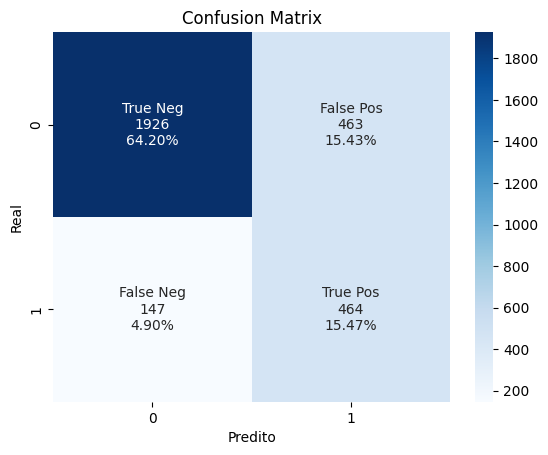

              precision    recall  f1-score   support

           0       0.93      0.81      0.86      2389
           1       0.50      0.76      0.60       611

    accuracy                           0.80      3000
   macro avg       0.71      0.78      0.73      3000
weighted avg       0.84      0.80      0.81      3000



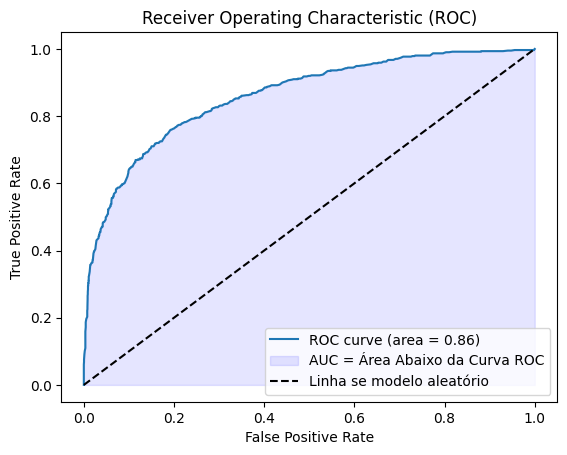

In [54]:
# Previsões no conjunto de teste
y_pred = best_model.predict(X_test_scaled)
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()

# Relatório de classificação
print(classification_report(y_test, y_pred))

# AUC-ROC
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.fill_between(fpr,tpr,color='blue',alpha= 0.1,label = 'AUC = Área Abaixo da Curva ROC')
plt.plot([0, 1], [0, 1], 'k--', label='Linha se modelo aleatório')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [55]:
import pickle

# Salvar o modelo
with open('random_forest_best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [56]:
# Pacote de Interpretabilidade
import shap

In [57]:
# Built-in feature importance
feature_names = best_model.feature_names_in_
importances = best_model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feature_names, 
                               'Importance': importances}
                               ).sort_values('Importance', ascending=False) 
feature_imp_df

Feature  Importance
0                  Idade    0.486743
1         Qte_Categorias    0.320506
2    Programa_Fidelidade    0.089382
3    Estado_Minas Gerais    0.075733
5       Estado_São Paulo    0.018307
4  Estado_Rio de Janeiro    0.009330

In [58]:
# Utilizar uma amostra de até 1.000 observações para extração do conhecimento
"""
X_sample = X_test_scaled.sample(1000, random_state=42)

rf_explainer = shap.TreeExplainer(model=best_model, 
                                  data=X_train_scaled)

rf_shap_values = rf_explainer.shap_values(X=X_sample)
"""

'\nX_sample = X_test_scaled.sample(1000, random_state=42)\n\nrf_explainer = shap.TreeExplainer(model=best_model, \n                                  data=X_train_scaled)\n\nrf_shap_values = rf_explainer.shap_values(X=X_sample)\n'

In [59]:
explainer = shap.TreeExplainer(best_model)
explanation = explainer(X_test_scaled)

shap_values = explanation.values

In [60]:
#features = X_test.iloc[X_sample.index]
features = X_test.copy()

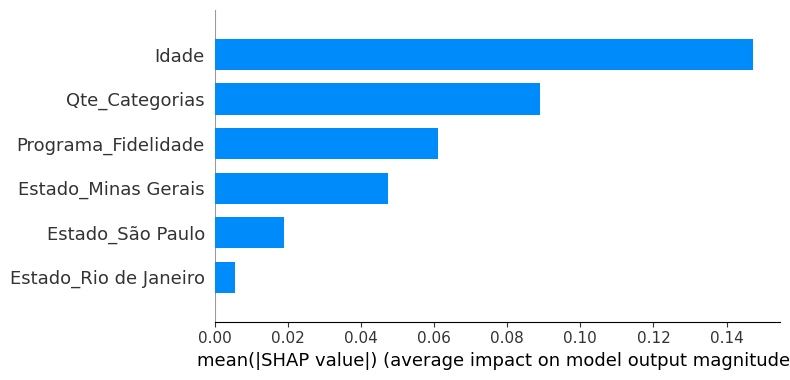

In [61]:
# ATENÇÃO: ajustar o shap_values de acordo com a saída do modelo
shap.summary_plot(shap_values=shap_values[..., 1],
                  plot_type='bar',
                  feature_names=feature_names,
            )

In [62]:
iv.get_iv_predict()

IV poder_separação
Variável                                        
Qte_Categorias_bin          0.84     Muito Forte
Idade_bin                   0.69     Muito Forte
Estado                      0.17           Médio
Programa_Fidelidade_bin     0.15           Médio
Limite_Credito_Mercado_bin  0.10           Médio
Gênero                      0.07           Fraco
DiaSemana                   0.01     Muito fraco
Score_Credito_bin           0.01     Muito fraco
Classe_Score                0.00     Muito fraco
Tempo_Cliente_bin           0.00     Muito fraco
Usa_Cartao_Credito_bin      0.00     Muito fraco
Sum_Pedidos_Acumulados_bin  0.00     Muito fraco

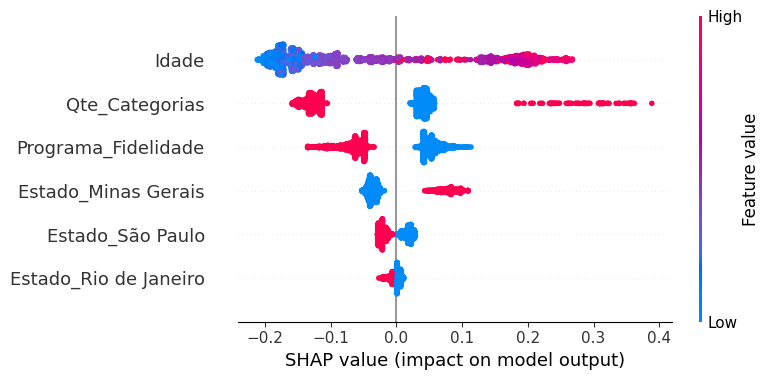

In [63]:
# ATENÇÃO: ajustar o shap_values de acordo com a saída do modelo
shap.summary_plot(shap_values=shap_values[..., 1], 
                  features=features,
                  feature_names=feature_names,
                  plot_type='dot')

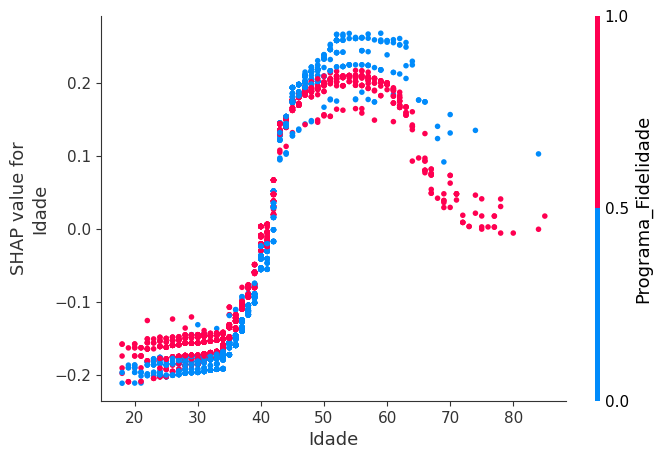

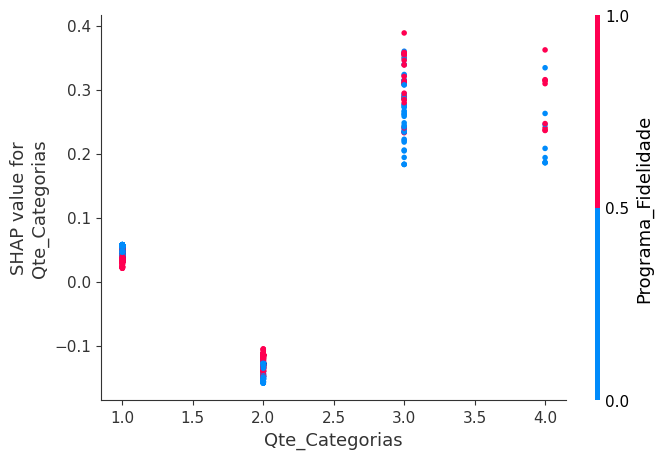

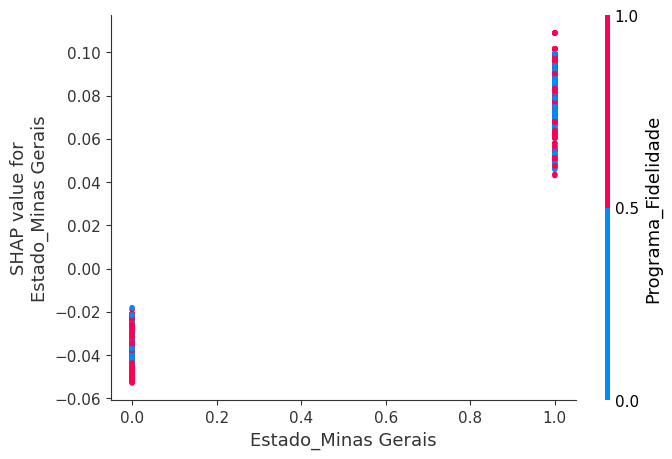

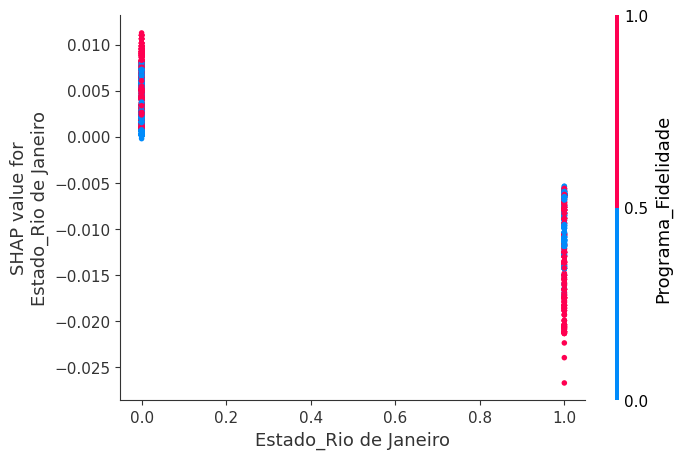

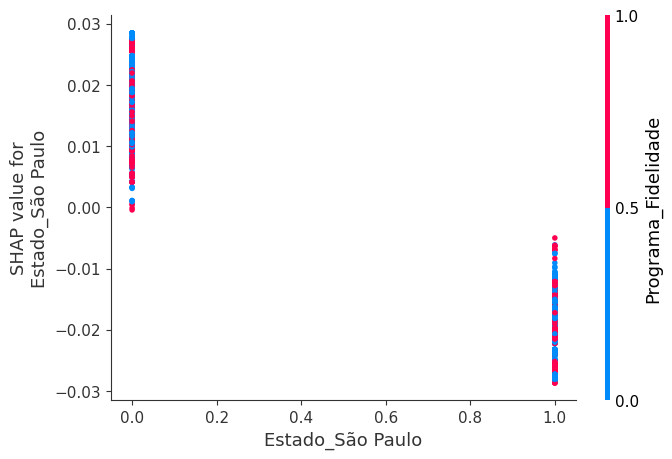

In [64]:
for name in feature_names:
    if name != 'Programa_Fidelidade':
        shap.dependence_plot(ind=name,
                            shap_values=shap_values[..., 1], 
                            features=features,
                            feature_names=feature_names, 
                            interaction_index='Programa_Fidelidade')

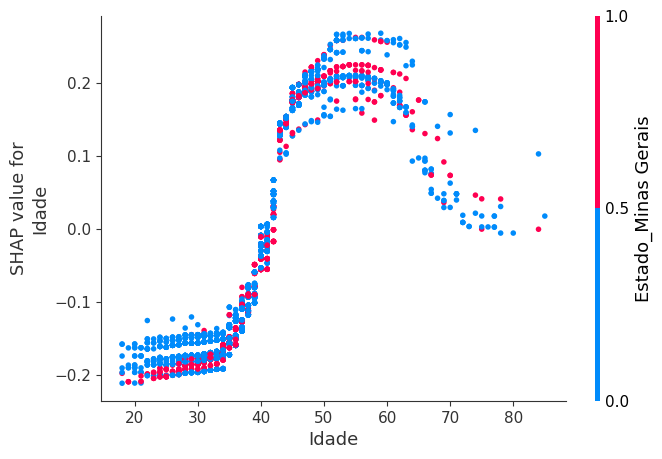

In [65]:
# Feature: Idade x Estado_Minas Gerais
shap.dependence_plot(ind='Idade', 
                     shap_values=shap_values[..., 1], 
                     features=features,
                     feature_names=feature_names, 
                     interaction_index='Estado_Minas Gerais')

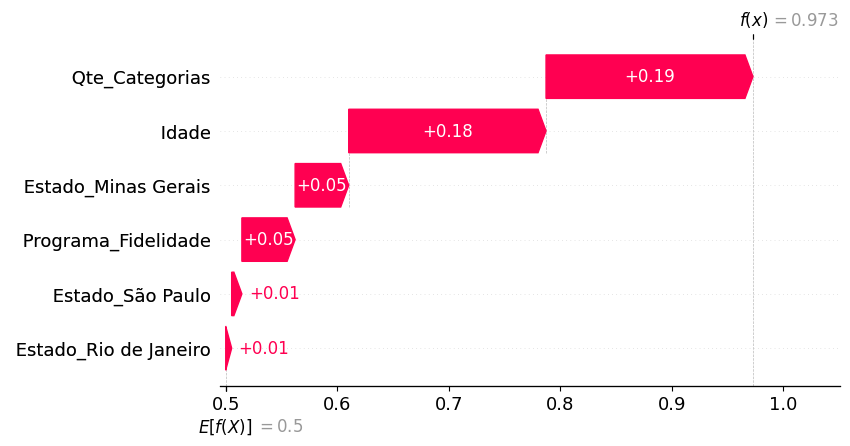

In [66]:
id_obs = 1580

shap.plots._waterfall.waterfall_legacy(expected_value=explainer.expected_value[1],
                                       shap_values=shap_values[..., 1][id_obs],
                                       feature_names=feature_names, 
                                       features=features.values[id_obs])

In [67]:
shap.initjs()

shap.force_plot(base_value=explainer.expected_value[1], 
                shap_values=shap_values[..., 1][id_obs],
                feature_names=feature_names,
                features=features.values[id_obs])

In [68]:
import pickle
# Carregar o modelo
with open('random_forest_best_model.pkl', 'rb') as file:
    best_model = pickle.load(file)

Os clientes ficam em média 4,93 meses.


In [69]:
# Quanto tempo os clientes que deram churn ficaram em média?
tempo_medio = df_churn[df_churn['Churn'] == 1]['Tempo_Cliente'].mean()
print(f'Os clientes ficam em média {valor(tempo_medio)} meses.')

df_backtest = df_churn[['Churn', 'Tempo_Cliente', 'Sum_Pedidos_Acumulados']].copy()

# Cálculo do Ticket Médio
df_backtest['Ticket_Medio_Mensal'] = df_backtest['Sum_Pedidos_Acumulados'] / 3  # valores nos últimos 3 meses

# Cálculo do CLV
df_backtest['LTV'] = df_backtest['Ticket_Medio_Mensal'] * tempo_medio

# Cálculo do LTV médio
ltv_medio = df_backtest['LTV'].mean()

print(f'LTV médio: {ltv_medio:.2f}')

Os clientes ficam em média 4,93 meses.
LTV médio: 685.72


In [70]:
n_cliente = 10_000

# Parâmetros financeiros
LTV = ltv_medio    # Lifetime Value
CAC = 150.00
CUPOM = 30.00   # Cupom de desconto para manter o cliente comprando

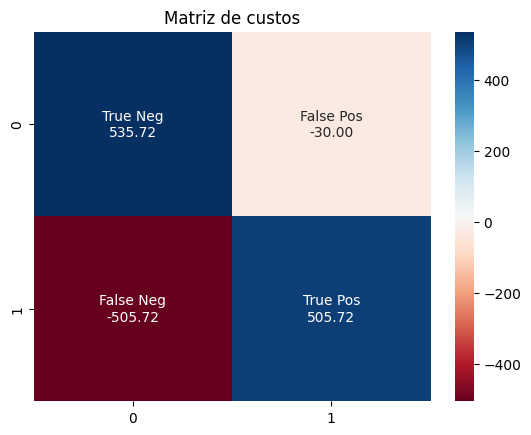

In [71]:
# Clientes que irão dar churn e foram corretamente classificados como churn pelo modelo.
impacto_TP = LTV - CAC - CUPOM

# Clientes que irão dar churn, mas foram incorretamente classificados como não churn pelo modelo.
impacto_FN = - impacto_TP # Perdemos a oportunidade de ganho caso o modelo acertasse.

# Clientes que NÃO irão dar churn e foram corretamente classificados como não churn pelo modelo.
impacto_TN = LTV - CAC

# Clientes que NÃO irão dar churn, mas foram incorretamente classificados como churn pelo modelo.
impacto_FP = impacto_TP - impacto_TN # Ganhamos o mesmo valor de TP, mas perdemos a oportunidade de ganho de TN caso o modelo acertasse.


# Criar a matriz de custos financeiro
matriz_custos = np.array([[impacto_TN, impacto_FP],
                          [impacto_FN, impacto_TP]])


# Matriz de impacto

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.2f}".format(value) for value in matriz_custos.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matriz_custos, annot=labels, fmt='', cmap='RdBu')
plt.title('Matriz de custos')
plt.show()

In [72]:
# Definir os cortes de probabilidade
thresholds = np.arange(0, 1.01, 0.01)

# Fazer previsões de probabilidade com o modelo carregado
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]


# Criar as matrizes de confusão e as matrizes de impacto para cada corte
impact_data = []

for threshold in thresholds:
    # Aplicar o corte de probabilidade para gerar previsões binárias
    y_pred = (y_prob >= threshold).astype(int)
    # Calcular a matriz de confusão
    conf_matrix = confusion_matrix(y_test, y_pred, normalize='all')
    # normalize='all') retorna a % de cada valor sobre o total, permitindo escalar para o total de clientes da base

    # Calcular o impacto financeiro para cada valor da matriz de confusão
    impacto_potencial = conf_matrix * matriz_custos * n_cliente
                     
    
    impact_data.append({
        'threshold': threshold,
        'TN': impacto_potencial[0, 0],
        'FP': impacto_potencial[0, 1],
        'FN': impacto_potencial[1, 0],
        'TP': impacto_potencial[1, 1],
        'impacto_potencial': impacto_potencial.sum(),
    })

# Criar DataFrame
df_impact = pd.DataFrame(impact_data).set_index('threshold')

# Mostrar o DataFrame
df_impact

TN        FP            FN            TP  \
threshold                                                       
0.00       0.000000e+00 -238900.0 -0.000000e+00  1.029986e+06   
0.01       0.000000e+00 -238900.0 -0.000000e+00  1.029986e+06   
0.02       0.000000e+00 -238900.0 -0.000000e+00  1.029986e+06   
0.03       0.000000e+00 -238900.0 -0.000000e+00  1.029986e+06   
0.04       0.000000e+00 -238900.0 -0.000000e+00  1.029986e+06   
...                 ...       ...           ...           ...   
0.96       4.266130e+06      -0.0 -1.019872e+06  1.011443e+04   
0.97       4.266130e+06      -0.0 -1.021558e+06  8.428693e+03   
0.98       4.266130e+06      -0.0 -1.029986e+06  0.000000e+00   
0.99       4.266130e+06      -0.0 -1.029986e+06  0.000000e+00   
1.00       4.266130e+06      -0.0 -1.029986e+06  0.000000e+00   

           impacto_potencial  
threshold                     
0.00            7.910863e+05  
0.01            7.910863e+05  
0.02            7.910863e+05  
0.03            7.910863e+05  
0.04            7.910863e+05  
...                      ...  
0.96            3.256372e+06  
0.97            3.253001e+06  
0.98            3.236143e+06  
0.99            3.236143e+06  
1.00            3.236143e+06  

[101 rows x 5 columns]

In [73]:
df_impact.reset_index(inplace=True)

In [74]:
import plotly.graph_objects as go



# Encontrar os valores mínimo e máximo do df
min = abs(df_impact.min().min())
min = -min - 10 ** int(np.log10(min))

max = abs(df_impact.max().max())
max = max + 10 ** int(np.log10(max))


# Encontrar o índice do maior impacto_potencial
threshold_index_inicial = df_impact['impacto_potencial'].idxmax()

# Função para criar a figura inicial do gráfico de cascata
def create_waterfall_figure(df, threshold_index):
    threshold = df['threshold'].iloc[threshold_index]
    values = [
        df['TN'].iloc[threshold_index],
        df['FP'].iloc[threshold_index],
        df['FN'].iloc[threshold_index],
        df['TP'].iloc[threshold_index],
    ]
    labels = ['TN', 'FP', 'FN', 'TP']
    total = df['impacto_potencial'].iloc[threshold_index]

    fig = go.Figure()

    fig.add_trace(go.Waterfall(
        name="Impacto Potencial",
        orientation="v",
        measure=["relative"] * len(values) + ["total"],
        x=labels + ['Impacto Potencial'],
        y=values + [total],
        base=0,
        connector={"line": {"color": "rgba(63, 63, 63, 0.8)"}},
        decreasing={"marker": {"color": "#e65a6d"}}, #red
        increasing={"marker": {"color": "#a3dce8"}}, #blue
        totals={"marker": {"color": "#003755" if total >= 0 else "red"}},
        text=[f"R$ {valor(v)}" for v in values] + [f"R$ {valor(total)}"]
    ))

    fig.update_layout(
        title=f"Impacto Potencial para {n_cliente} clientes com Threshold {threshold:.2f}",
        xaxis_title="Categoria",
        yaxis_title="Impacto Financeiro (R$)",
        title_font_size=20,
        xaxis_title_font_size=16,
        yaxis_title_font_size=16,
        yaxis=dict(range=[min, max])
    )

    return fig

# Criação inicial da figura
fig = create_waterfall_figure(df_impact, threshold_index_inicial)

# Criar o controle deslizante
steps = []
for i in range(len(thresholds)):

    step = {
        'method': 'update',
        'args': [
            {
                'y': [
                    [df_impact['TN'].iloc[i], 
                     df_impact['FP'].iloc[i], 
                     df_impact['FN'].iloc[i], 
                     df_impact['TP'].iloc[i], 
                     df_impact['impacto_potencial'].iloc[i]],  # Valores do gráfico de cascata e impacto total
                ],
                'totals':{"marker": {"color": "#003755" if df_impact['impacto_potencial'].iloc[i] >= 0 else "red"}},
                'text': [
                    [f"R$ {valor(v)}" for v in [df_impact['TN'].iloc[i],
                                                df_impact['FP'].iloc[i], 
                                                df_impact['FN'].iloc[i], 
                                                df_impact['TP'].iloc[i], 
                                                df_impact['impacto_potencial'].iloc[i]]]  # Textos
                ]
            },
            {'title': f"Impacto Potencial para {n_cliente} clientes com Threshold {df_impact['threshold'].iloc[i]:.2f}"}
        ],
        'label': f"{thresholds[i]:.2f}"    
    }
    steps.append(step)

sliders = [{
    'active': threshold_index_inicial,
    'pad': {"t": 50},
    'steps': steps
}]

fig.update_layout(
    sliders=sliders
)

# Mostrar o gráfico
fig.show()


In [75]:
import plotly.express as px


# Encontrar o índice e o valor do maior impacto_potencial
max_index = df_impact['impacto_potencial'].idxmax()
max_value = df_impact['impacto_potencial'].max()

# Criar gráfico de barras para o impacto total
fig_bar = px.bar(df_impact, x='threshold', y='impacto_potencial',
                 title=f'Impacto Potencial para {n_cliente} vs Threshold',
                 labels={'threshold': 'Threshold', 'impacto_potencial': 'Impacto Potencial (R$)'})

# Alterar a cor da barra máxima
colors = ['#e65a6d'] * len(df_impact) #red
colors[max_index] = '#003755'  # Destacar a barra máxima com cor azul

fig_bar.update_traces(marker_color=colors)

# Adicionar anotação para o valor mais alto
fig_bar.add_annotation(
    x=df_impact['threshold'][max_index],
    y=max_value,
    text=f'Valor máximo: R$ {valor(max_value)}',
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=-30,
    font=dict(color="#003755", size=12)
)

fig_bar.update_layout(
    title_font_size=20,
    xaxis_title_font_size=16,
    yaxis_title_font_size=16
)

fig_bar.show()


In [76]:
# valor potencial com o melhor ajuste no corte de probabilidades
value_model = max_value 

# valor estimado caso sem uso do modelo
value_no_model = df_impact[df_impact['threshold'] == 1]['impacto_potencial'].values[0]

In [77]:
ganho_em_valor_financeiro = value_model - value_no_model
ganho = (value_model / value_no_model - 1)
print(f'O ganho em relação ao método atual é de R$ {valor(ganho_em_valor_financeiro)} ({ganho:.2%})')

O ganho em relação ao método atual é de R$ 871.727,41 (26.94%)
